In [30]:
import warnings

warnings.filterwarnings("ignore")

In [31]:
# @title bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller


O dataset

In [32]:
df = pd.read_csv('dataset/superstore.csv')

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# limpeza do dataset

In [33]:
colunas_remover = ['Order ID', 'Country', 'Ship Date', 'Ship Mode', 'Customer ID', 'State', 'Postal Code', 'Region', 'Product ID','Country','Segment']

df = df.drop(colunas_remover, axis=1)

In [34]:
df.head()

,Row ID,Order Date,Customer Name,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,11/8/2016,Claire Gute,Henderson,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,11/8/2016,Claire Gute,Henderson,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,6/12/2016,Darrin Van Huff,Los Angeles,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,10/11/2015,Sean O'Donnell,Fort Lauderdale,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,10/11/2015,Sean O'Donnell,Fort Lauderdale,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [35]:
dict_preco_unit = {}

for i, row in df.iterrows():
    dict_preco_unit[row['Row ID']] = (row['City'],row['Sales'] / row['Quantity'])

print(f"Min value = {min(dict_preco_unit.values())}")
print(f"Max value = {max(dict_preco_unit.values())}")

df['Unit_Price'] = df['Sales'] / df['Quantity']
df['Unit_Price']
df['Cost'] = df['Sales'] - df['Profit'] 
df.head()

Min value = ('Aberdeen', 8.5)
Max value = ('Yuma', 119.997)


,Row ID,Order Date,Customer Name,City,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Unit_Price,Cost
0,1,11/8/2016,Claire Gute,Henderson,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,130.9800,220.0464
1,2,11/8/2016,Claire Gute,Henderson,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,243.9800,512.3580
2,3,6/12/2016,Darrin Van Huff,Los Angeles,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,7.3100,7.7486
3,4,10/11/2015,Sean O'Donnell,Fort Lauderdale,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,191.5155,1340.6085
4,5,10/11/2015,Sean O'Donnell,Fort Lauderdale,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,11.1840,19.8516


In [36]:
#staples é o mais vendido em relação a qtd
df.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).head(10)

Product Name
Staples                                                       215
Staple envelope                                               170
Easy-staple paper                                             150
Staples in misc. colors                                        86
KI Adjustable-Height Table                                     74
Storex Dura Pro Binders                                        71
Avery Non-Stick Binders                                        71
GBC Premium Transparent Covers with Diagonal Lined Pattern     67
Situations Contoured Folding Chairs, 4/Set                     64
Staple-based wall hangings                                     62
Name: Quantity, dtype: int64

In [37]:
#so o prod + vendido
df = df.loc[df['Product Name'] == 'Staples']

In [38]:
colunas_remover = ['Category', 'Sub-Category', 'Product Name']

df = df.drop(colunas_remover, axis=1)


In [39]:
#acertando o formato das datas
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day

df = df.sort_values(by='Order Date')

print('Menor data: ', df['Year'].min())
print('Maior data: ', df['Year'].max())

Menor data:  2014
Maior data:  2017


In [40]:
df

,Row ID,Order Date,Customer Name,City,Sales,Quantity,Discount,Profit,Unit_Price,Cost,Year,Month,Day
1703,1704,2014-02-02,Cynthia Delaney,San Diego,12.350,5,0.0,5.8045,2.470,6.5455,2014,2,2
2701,2702,2014-03-18,Sean Miller,Jacksonville,18.936,3,0.2,5.9175,6.312,13.0185,2014,3,18
342,343,2014-04-13,Jonathan Doherty,Philadelphia,30.992,13,0.2,10.0724,2.384,20.9196,2014,4,13
1886,1887,2014-05-13,Erica Hernandez,Hialeah,7.104,2,0.2,2.3976,3.552,4.7064,2014,5,13
2923,2924,2014-06-28,Rob Williams,Detroit,6.080,1,0.0,3.0400,6.080,3.0400,2014,6,28
4502,4503,2014-06-30,Michael Stewart,Houston,21.312,6,0.2,7.1928,3.552,14.1192,2014,6,30
3223,3224,2014-10-02,Erin Smith,Tempe,4.672,2,0.2,1.4600,2.336,3.2120,2014,10,2
2059,2060,2014-10-31,Greg Guthrie,Los Angeles,11.340,3,0.0,5.2164,3.780,6.1236,2014,10,31
4065,4066,2014-11-01,Ken Heidel,Charlotte,7.520,5,0.2,1.4100,1.504,6.1100,2014,11,1
1485,1486,2014-11-27,Maxwell Schwartz,New York City,3.760,2,0.0,1.3160,1.880,2.4440,2014,11,27


# Análise Exploratória

In [41]:
data = df['Sales']

#verificação estacionaridade
if adfuller(data)[1] > 0.05:
    print("A série não é estacionária. Diferenciação necessária.")
else:
    print("A série é estacionária. Nenhuma diferenciação necessária.")
    

A série é estacionária. Nenhuma diferenciação necessária.


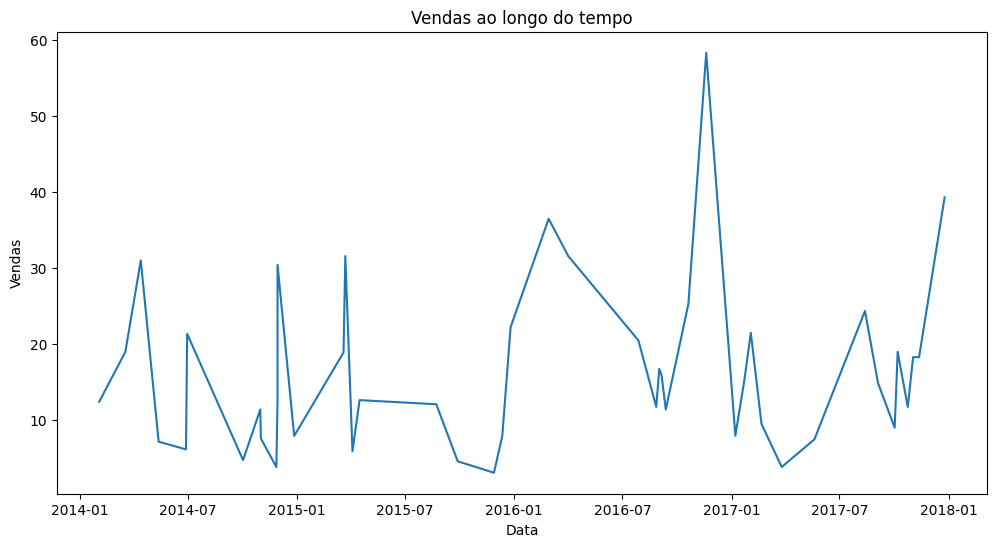

In [42]:
df_serie = df.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df['Order Date'], df['Sales'])
plt.title('Vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()


In [43]:
print(df_serie.info())
print(df_serie.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  45 non-null     datetime64[ns]
 1   Sales       45 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 852.0 bytes
None
                Order Date      Sales
count                   45  45.000000
mean   2016-03-03 10:40:00  16.788222
min    2014-02-02 00:00:00   3.008000
25%    2014-12-27 00:00:00   7.860000
50%    2016-04-01 00:00:00  14.820000
75%    2017-02-20 00:00:00  21.312000
max    2017-12-25 00:00:00  58.368000
std                    NaN  11.723635


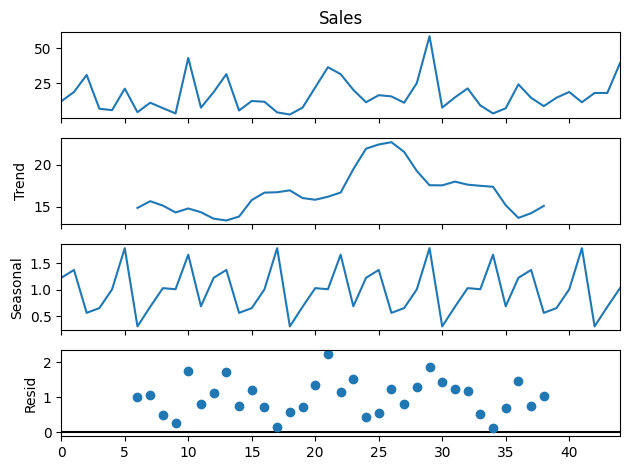

In [44]:
decomposition = seasonal_decompose(df_serie['Sales'], model='multiplicative', period=12)

decomposition.plot()
plt.show()

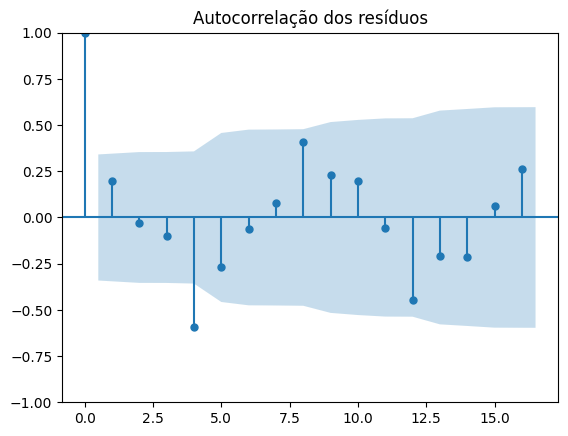

In [45]:
residuo = decomposition.resid.dropna()

plot_acf(residuo)
plt.title('Autocorrelação dos resíduos')
plt.show()


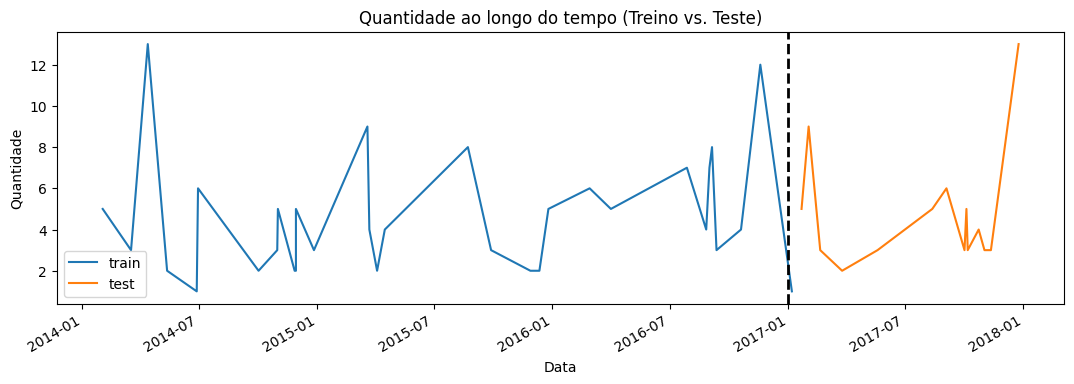

In [46]:
color_pal = ['#1f77b4', '#ff7f0e']

df.set_index('Order Date', inplace=True)

train = df.loc[df.index < '2017-01-12']
test = df.loc[df.index >= '2017-01-12']

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
train['Quantity'].plot(ax=ax, color=color_pal[0])
test['Quantity'].plot(ax=ax, color=color_pal[1])
ax.axvline('2017-01-01', color='black', linestyle='--', lw=2)
ax.legend(['train', 'test'])
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.title('Quantidade ao longo do tempo (Treino vs. Teste)')
plt.show()

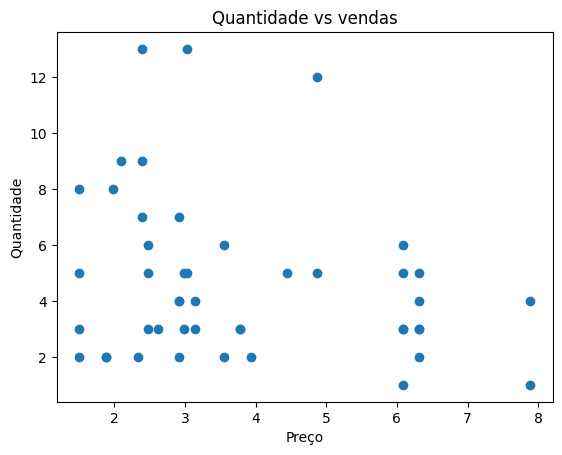

In [47]:
#dispersão
plt.scatter(df['Unit_Price'], df['Quantity'])
plt.xlabel('Preço')
plt.ylabel('Quantidade')
plt.title('Quantidade vs vendas')
plt.show()

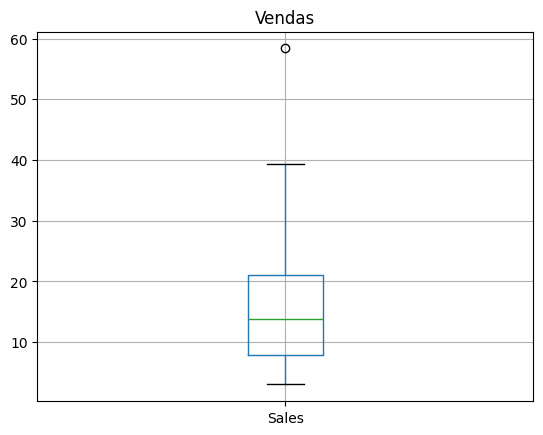

,Row ID,Customer Name,City,Sales,Quantity,Discount,Profit,Unit_Price,Cost,Year,Month,Day
Order Date,,,,,,,,,,,,
2016-11-19,1109,Eric Hoffmann,Houston,58.368,12,0.2,21.888,4.864,36.48,2016,11,19


In [48]:
#outliers
df.boxplot(column=['Sales'])
plt.title('Vendas')
plt.show()

z_scores = stats.zscore(df['Sales'])
outliers = df[np.abs(z_scores) > 3]

outliers
     

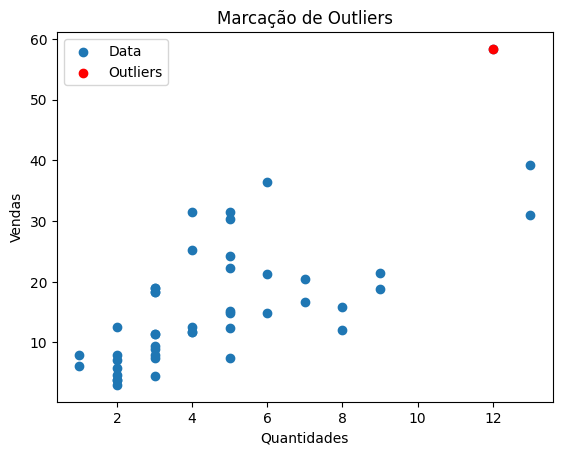

In [49]:
#dispersão com outlier destacado
plt.scatter(df['Quantity'], df['Sales'], label='Data')
plt.scatter(outliers['Quantity'], outliers['Sales'], color='red', label='Outliers')
plt.xlabel('Quantidades')
plt.ylabel('Vendas')
plt.title('Marcação de Outliers')
plt.legend()
plt.show()


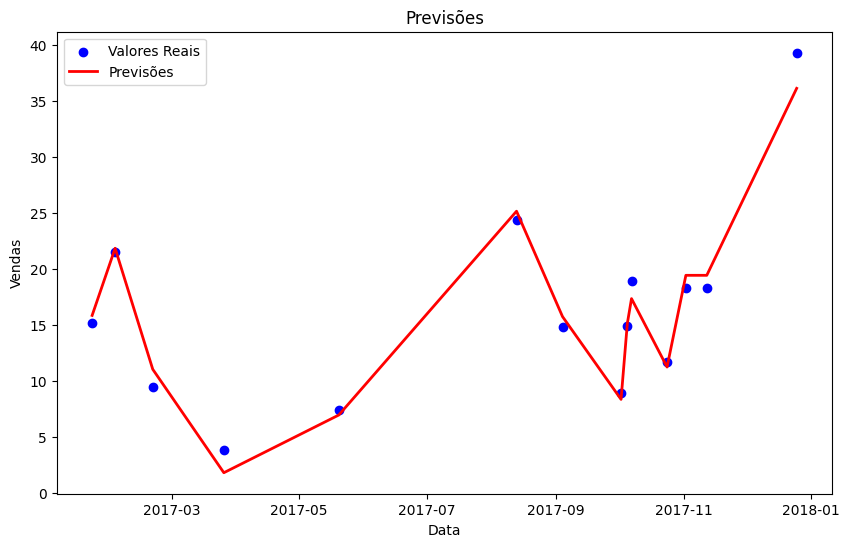

In [50]:
train = df.loc[df.index < '2017-01-12']
test = df.loc[df.index >= '2017-01-12']

categorical_columns = ['Quantity', 'Discount', 'Profit'] 

#características (X) e alvo (y)
X_train = train.drop(columns=['Sales'])
y_train = train['Sales']
X_test = test.drop(columns=['Sales'])
y_test = test['Sales']

#modelo de regressão linear
model = LinearRegression()
train['Quantity'] = train['Quantity'].astype('float')
train['Discount'] = train['Discount'].astype('float')
test['Quantity'] = test['Quantity'].astype('float')
test['Discount'] = test['Discount'].astype('float')

X_train = X_train[categorical_columns]
X_test = X_test[categorical_columns]

model.fit(X_train, y_train)

#previsão
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(test.index, y_test, color='blue', label='Valores Reais')
plt.plot(test.index, y_pred, color='red', linewidth=2, label='Previsões')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Previsões')
plt.legend()
plt.show()


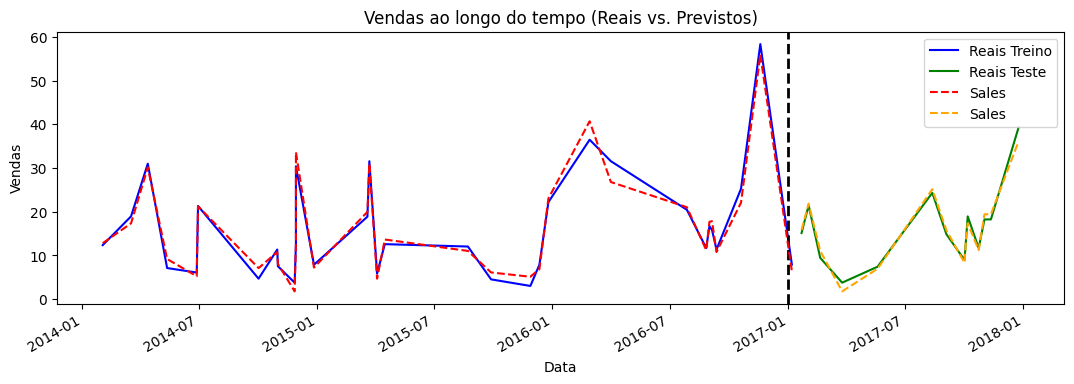

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(13, 4))


#reais para o conjunto de treino
train['Sales'].plot(ax=ax, color='blue', label='Reais Treino')

#previstos para o conjunto de treino
train_pred = pd.Series(model.predict(X_train), index=X_train.index)

#reais para o conjunto de teste
test['Sales'].plot(ax=ax, color='green', label='Reais Teste')

#previstos para o conjunto de teste
test_pred = pd.Series(model.predict(X_test), index=X_test.index)

test_pred = pd.DataFrame(test_pred, columns=['Sales'])
train_pred = pd.DataFrame(train_pred, columns=['Sales'])

test_pred = test_pred.sort_values(by='Order Date')
train_pred = train_pred.sort_values(by='Order Date')


#divisão entre treino e teste
ax.axvline('2017-01-01', color='black', linestyle='--', lw=2)

train_pred.plot(ax=ax, color='red', linestyle='--', label='Previstos Treino')
test_pred.plot(ax=ax, color='orange', linestyle='--', label='Previstos Teste')

ax.legend()
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Vendas ao longo do tempo (Reais vs. Previstos)')
plt.show()


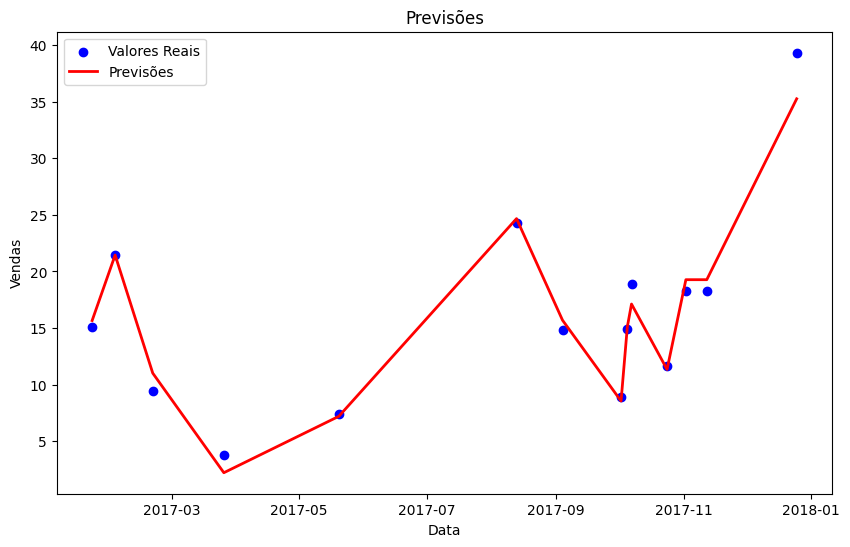

In [52]:
#IQR (intervalo interquartil, é uma medida estatistica para dispersão dos dados)
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

#df sem outliers
df_sem_outliers = df[~((df['Sales'] < (Q1 - 1.5 * IQR)) | (df['Sales'] > (Q3 + 1.5 * IQR)))]

train_sem_outliers = df_sem_outliers.loc[df_sem_outliers.index < '2017-01-12']
test_sem_outliers = df_sem_outliers.loc[df_sem_outliers.index >= '2017-01-12']

categorical_columns = ['Quantity', 'Discount', 'Profit'] 

#características (X) e alvo (y)
X_train_sem_outliers = train_sem_outliers.drop(columns=['Sales'])
y_train_sem_outliers = train_sem_outliers['Sales']
X_test_sem_outliers = test_sem_outliers.drop(columns=['Sales'])
y_test_sem_outliers = test_sem_outliers['Sales']

#modelo de regressão linear
model = LinearRegression()
train_sem_outliers['Quantity'] = train_sem_outliers['Quantity'].astype('float')
train_sem_outliers['Discount'] = train_sem_outliers['Discount'].astype('float')
test_sem_outliers['Quantity'] = test_sem_outliers['Quantity'].astype('float')
test_sem_outliers['Discount'] = test_sem_outliers['Discount'].astype('float')

X_train_sem_outliers = X_train_sem_outliers[categorical_columns]
X_test_sem_outliers = X_test_sem_outliers[categorical_columns]

#treinando modelo sem outliers
model_sem_outliers = LinearRegression()
model_sem_outliers.fit(X_train_sem_outliers, y_train_sem_outliers)
y_pred_sem_outliers = model_sem_outliers.predict(X_test_sem_outliers)
mse_without_outliers = mean_squared_error(y_test_sem_outliers, y_pred_sem_outliers)
mse_with_outliers = mean_squared_error(y_test, y_pred)


plt.figure(figsize=(10, 6))
plt.scatter(test_sem_outliers.index, y_test_sem_outliers, color='blue', label='Valores Reais')
plt.plot(test_sem_outliers.index, y_pred_sem_outliers, color='red', linewidth=2, label='Previsões')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Previsões')
plt.legend()
plt.show()


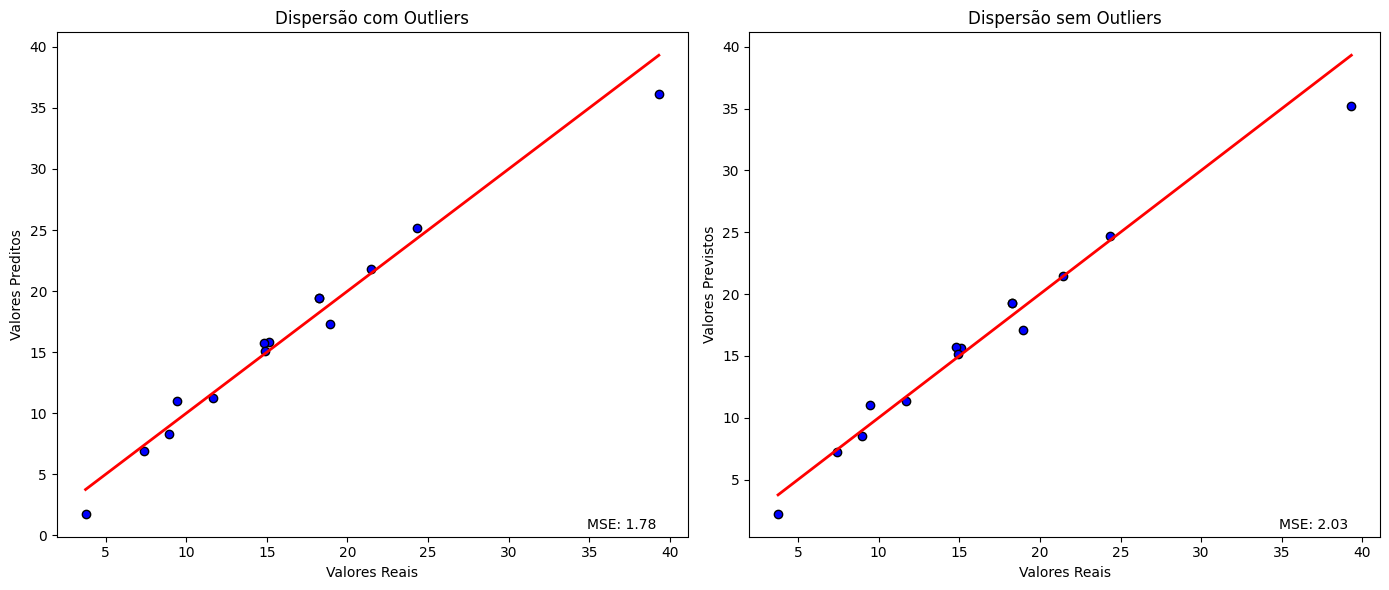

MSE com outliers: 1.7822482564243423
MSE sem outliers: 2.026119080606887


In [53]:
plt.figure(figsize=(14, 6))

#com outliers
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Dispersão com Outliers')
plt.text(0.95, 0.01, f'MSE: {mse_with_outliers:.2f}', transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')

#sem outliers
plt.subplot(1, 2, 2)
plt.scatter(y_test_sem_outliers, y_pred_sem_outliers, color='blue', edgecolor='k')
plt.plot([y_test_sem_outliers.min(), y_test_sem_outliers.max()], [y_test_sem_outliers.min(), y_test_sem_outliers.max()], color='red', linewidth=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Dispersão sem Outliers')
plt.text(0.95, 0.01, f'MSE: {mse_without_outliers:.2f}', transform=plt.gca().transAxes, verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.show()

print(f'MSE com outliers: {mse_with_outliers}')
print(f'MSE sem outliers: {mse_without_outliers}')


In [54]:
#métricas de erro
rmse = np.sqrt(mse_with_outliers)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erro Quadrático Médio (MSE): {mse_with_outliers:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

print('')
print("MSE = Mean Squared Error")
print("MSE com outliers:", mse_with_outliers)
print("MSE sem outliers:", mse_without_outliers)


Erro Quadrático Médio (MSE): 1.78
Raiz do Erro Quadrático Médio (RMSE): 1.34
Erro Absoluto Médio (MAE): 1.09
Coeficiente de Determinação (R²): 0.98

MSE = Mean Squared Error
MSE com outliers: 1.7822482564243423
MSE sem outliers: 2.026119080606887


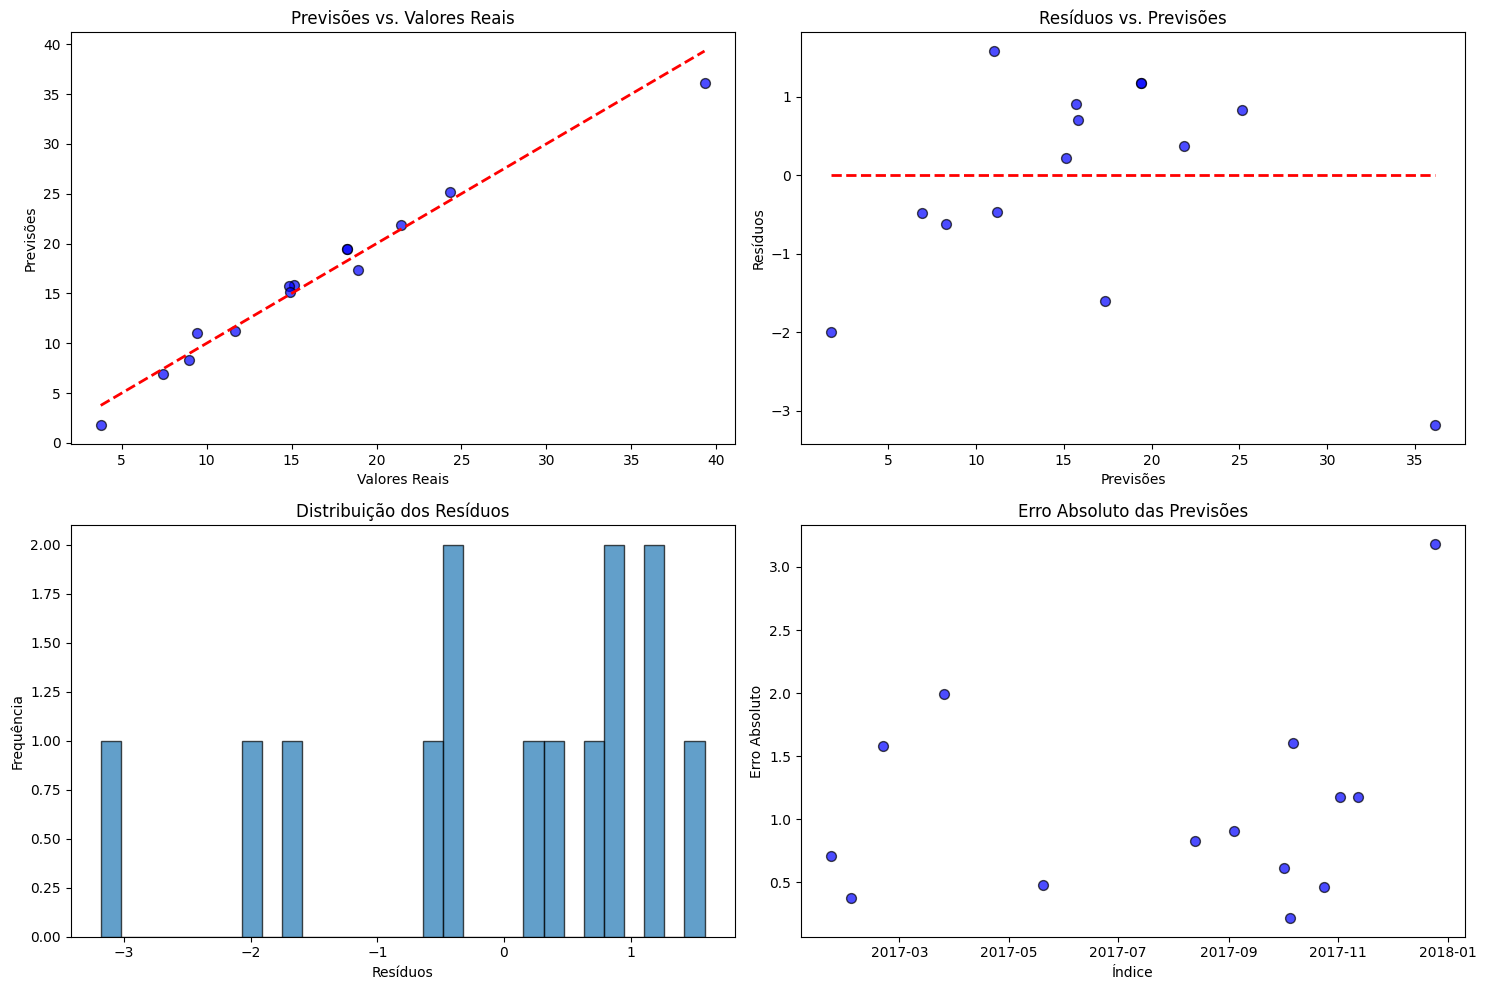

In [55]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', s=50, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais')

plt.subplot(2, 2, 2)
plt.scatter(y_pred, y_pred - y_test, color='blue', edgecolor='k', s=50, alpha=0.7)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), color='red', linestyle='--', linewidth=2)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Previsões')

plt.subplot(2, 2, 3)
plt.hist(y_pred - y_test, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')

plt.subplot(2, 2, 4)
plt.scatter(y_test.index, np.abs(y_pred - y_test), color='blue', edgecolor='k', s=50, alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Erro Absoluto')
plt.title('Erro Absoluto das Previsões')

plt.tight_layout()
plt.show()


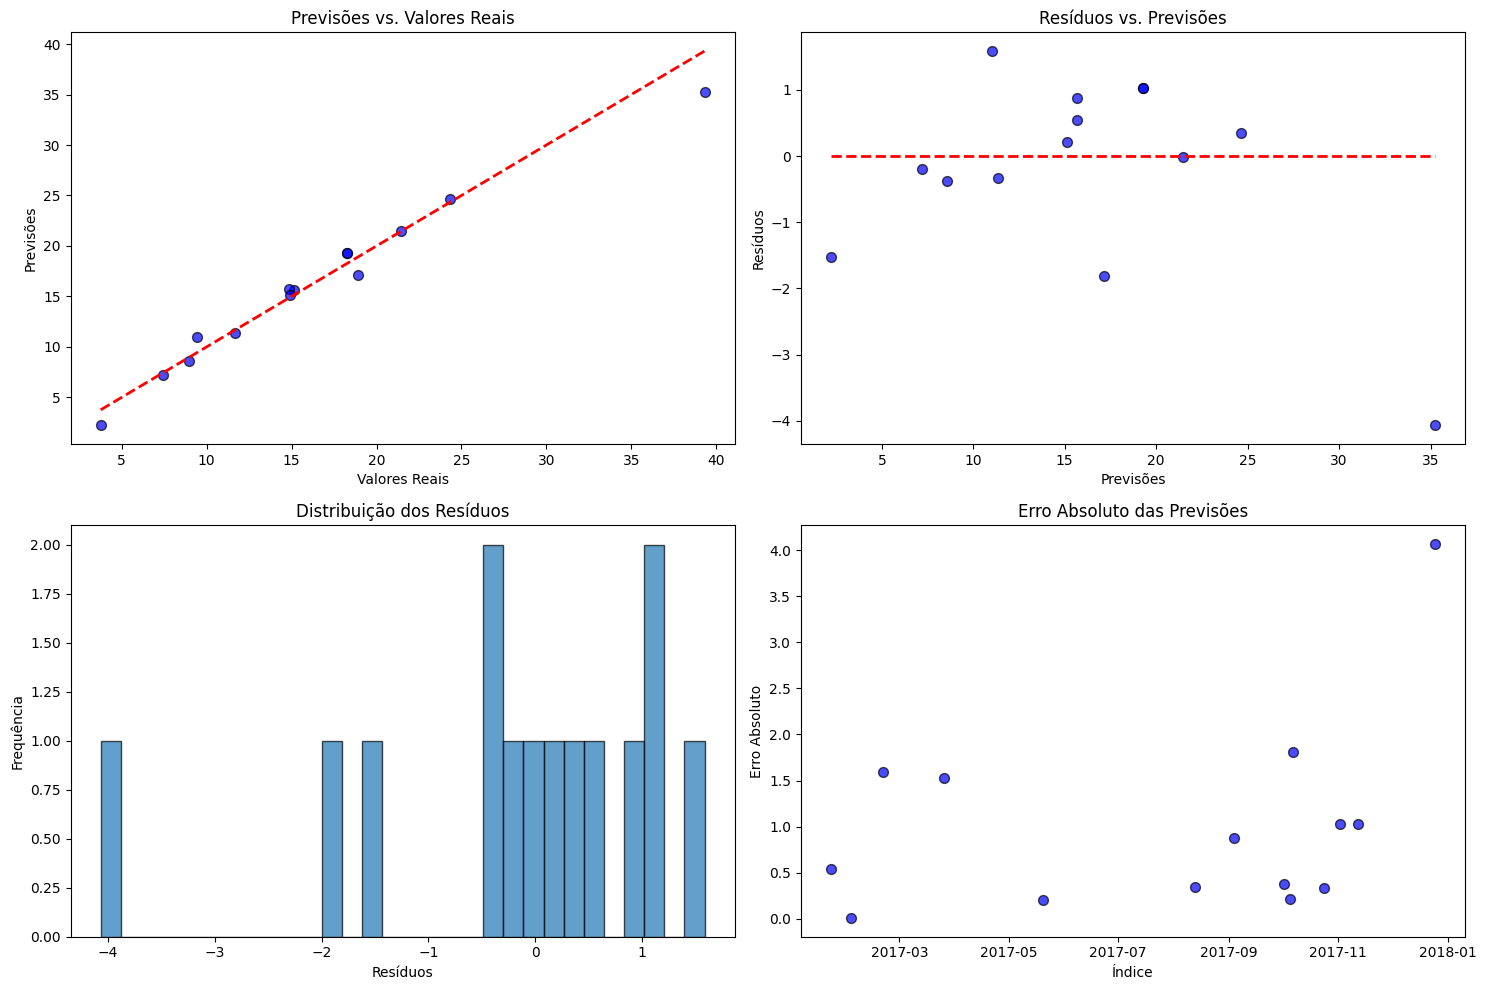

In [56]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(y_test_sem_outliers, y_pred_sem_outliers, color='blue', edgecolor='k', s=50, alpha=0.7)
plt.plot([y_test_sem_outliers.min(), y_test_sem_outliers.max()], [y_test_sem_outliers.min(), y_test_sem_outliers.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais')

plt.subplot(2, 2, 2)
plt.scatter(y_pred_sem_outliers, y_pred_sem_outliers - y_test_sem_outliers, color='blue', edgecolor='k', s=50, alpha=0.7)
plt.hlines(y=0, xmin=y_pred_sem_outliers.min(), xmax=y_pred_sem_outliers.max(), color='red', linestyle='--', linewidth=2)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Previsões')

plt.subplot(2, 2, 3)
plt.hist(y_pred_sem_outliers - y_test_sem_outliers, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')

plt.subplot(2, 2, 4)
plt.scatter(y_test_sem_outliers.index, np.abs(y_pred_sem_outliers - y_test_sem_outliers), color='blue', edgecolor='k', s=50, alpha=0.7)
plt.xlabel('Índice')
plt.ylabel('Erro Absoluto')
plt.title('Erro Absoluto das Previsões')

plt.tight_layout()
plt.show()

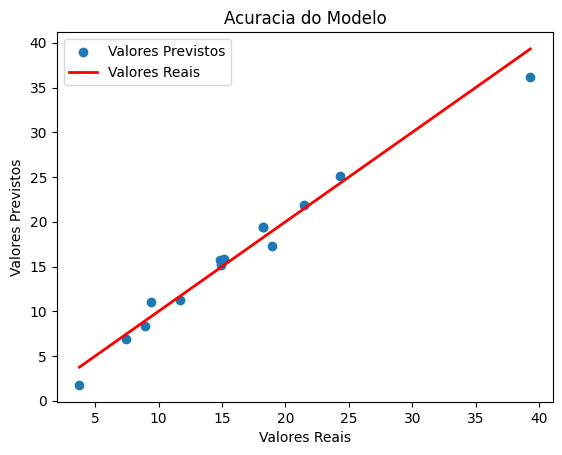

In [57]:
plt.scatter(y_test, y_pred, label='Valores Previstos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Acuracia do Modelo')
plt.legend()
plt.show()

In [58]:
y_pred, y_test

(array([15.83023445, 21.83342324, 11.01471558,  1.7704231 ,  6.92985502,
        25.14570005, 15.72520119,  8.32451709, 15.11785593, 17.33155806,
        11.21798304, 19.41536958, 19.41536958, 36.12883818]),
 Order Date
 2017-01-22    15.120
 2017-02-02    21.456
 2017-02-20     9.432
 2017-03-26     3.760
 2017-05-20     7.410
 2017-08-13    24.320
 2017-09-04    14.820
 2017-10-02     8.940
 2017-10-05    14.900
 2017-10-07    18.936
 2017-10-24    11.680
 2017-11-02    18.240
 2017-11-12    18.240
 2017-12-25    39.312
 Name: Sales, dtype: float64)

# Previsão Futuro [Next Steps]

In [59]:
df

,Row ID,Customer Name,City,Sales,Quantity,Discount,Profit,Unit_Price,Cost,Year,Month,Day
Order Date,,,,,,,,,,,,
2014-02-02,1704,Cynthia Delaney,San Diego,12.350,5,0.0,5.8045,2.470,6.5455,2014,2,2
2014-03-18,2702,Sean Miller,Jacksonville,18.936,3,0.2,5.9175,6.312,13.0185,2014,3,18
2014-04-13,343,Jonathan Doherty,Philadelphia,30.992,13,0.2,10.0724,2.384,20.9196,2014,4,13
2014-05-13,1887,Erica Hernandez,Hialeah,7.104,2,0.2,2.3976,3.552,4.7064,2014,5,13
2014-06-28,2924,Rob Williams,Detroit,6.080,1,0.0,3.0400,6.080,3.0400,2014,6,28
2014-06-30,4503,Michael Stewart,Houston,21.312,6,0.2,7.1928,3.552,14.1192,2014,6,30
2014-10-02,3224,Erin Smith,Tempe,4.672,2,0.2,1.4600,2.336,3.2120,2014,10,2
2014-10-31,2060,Greg Guthrie,Los Angeles,11.340,3,0.0,5.2164,3.780,6.1236,2014,10,31
2014-11-01,4066,Ken Heidel,Charlotte,7.520,5,0.2,1.4100,1.504,6.1100,2014,11,1
